In [1]:
"""
File for modelling full sampling procedure, with rotation rate, voltage fitting, profiling speed, etc.

"""

import numpy as np
import pandas as pd
from scipy.io import netcdf
from scipy.io import loadmat, savemat
from scipy import signal
from datetime import datetime
import matplotlib.pyplot as plt
import random as rand
import pyIGRF
from src.spectral_processing import *
import os
import warnings




%load_ext autoreload
%autoreload 2

cdip_color='#F5B958'
red_color = '#D81159'
gray_color= '#2E2836'

In [2]:
# Step 1 Pick a wave spectra


def load_CDIP(fname):
    
    #fname = "/Volumes/TFO-exFAT-1/TFO/LCDRI/CDIPwaverider229/229p1_d01.nc";
    nc = netcdf.NetCDFFile(fname, 'r', mmap=False) #Not sure why I need to do mmap = False but it gets rid of a warning
    time = nc.variables['waveTime'][:]
    Hs = nc.variables['waveHs'][:]
    energy_density = nc.variables['waveEnergyDensity'][:]
    wave_freq = nc.variables['waveFrequency'][:]
    #dtimes = datetime(time, 'convertfrom', 'posixtime');
    nc.close()
    
    return(np.array(time.data), np.array(wave_freq.data), np.array(energy_density.data))



In [3]:
# Step 2: Make a record of x-y-z positions of float

def apex_sampling_grid(start_z, end_z, prof_speed, u_prof, v_prof, sample_rate=1):
    """
    Inputs:
        start_z: Initial depth

        end_z: Final Depth

        prof_speed: Profiling spped (m/s)

        Sample_rate: Sampling frequency (defauly 1Hz for Em-APEX float)
        
    Outputs:
        
    """
    t_length = np.abs(np.abs(end_z-start_z)/prof_speed)
    num_samples = np.abs(int(t_length*sample_rate))
    z_range = np.linspace(start_z, end_z, num_samples)
    t_array = np.linspace(0, t_length, num_samples)

    #Get the z-position
    em_z = t_array*prof_speed+start_z

    #Get the x-position
    em_x, em_y = get_xy_position(u_prof, v_prof)
    
    return(em_x, em_y, em_z)

def get_xy_position(u_prof, v_prof):
    """
        Returns x-y-position of float given some horizontal-velocity-profile
    """
    em_x = np.zeros(len(u_prof))
    em_y = np.zeros(len(v_prof))
    for i in range(len(u_prof)):
        em_x[i] = np.trapz(u_prof[:i])
        em_y[i] = np.trapz(v_prof[:i])
        
    return(em_x, em_y)
        

In [4]:
# Step 2: Build a wave based timeseries of u. Add to it the mean u profile

def build_u_timeseries(em_x, em_y, em_z, input_spectra, f, theta_spec, n_iter, fy=1, fz=1):

    fs = 1
    u_store = np.zeros((n_iter, len(em_x)))
    v_store = np.zeros((n_iter, len(em_x)))

    t_range = np.linspace(0, len(em_x), len(em_x))
    #Number of iterations to run
    #zeta_store = np.zeros((n_iter, len(t_range)))
    t = 0
    x = 0
    #Try interpolating the spectra
    #f_target = np.linspace(f[0], f[-1], 128)
    #input_spectra = np.interp(f_target, f, input_spectra)
    #f= f_target
    
    #theta_spec = np.ones(len(f))*-1*np.pi/4


    #plt.figure()
    #plt.loglog(f_target, )
    for jj in range(0, n_iter):
        for i in range(0, len(f-1)):#:#len(f)-1:
            freq = f[i]
            if i == 0:
                df = f[1]-f[0]
            elif i == len(f)-1:
                df = f[i]-f[i-1]
            else:
                df = (f[i+1]-f[i-1])/2
            omega = 2*np.pi*freq;
            k = np.square(omega)/9.8
            
            #This is assuming theta is angle CCW from east
            kx = k * np.cos(theta_spec[i])
            ky = k * np.sin(theta_spec[i])
            
            #Is there a 2 in here or not?
            a = np.sqrt(input_spectra[i]*df*2) # Is this the right conversion to wave amplitude? 

            #Randomize phase
            phi = rand.random()*2*np.pi

             
            beta = (fy/fz)*np.sin(theta_spec[i])
            u = np.sqrt(1+beta**2)*a*omega*np.cos(kx*em_x+ky*em_y-omega*t_range + phi)*np.exp(-k*em_z)*np.cos(theta_spec[i])
            v = a*omega*np.cos(ky*em_y+kx*em_x-omega*t_range + phi)*np.exp(-k*em_z)*np.sin(theta_spec[i])
            
            #zeta = a*np.cos(k*x-omega*t_range + phi)
            #print(u)
            u_store[jj, :] = u_store[jj, :] + u
            v_store[jj, :] = v_store[jj, :] + v
    #how do we choose the amplitude for each frequency?



    ## Add white noise
    
    #First generate a white noise with the std of an EM-APEX float white noise situation
    #TO DO: Check if "uncertainty of 0.8-1.5 cm/s" means that's 1 Std or rms or what
    mean = 0
    std = 0.01 
    num_samples = len(u_store[:, 0])*len(u_store[0, :])
    rand_samples = 0.008*np.random.normal(loc = 0, scale = 1, size = num_samples)

    rand_samples = rand_samples.reshape((len(u_store[:, 0]), len(u_store[0, :])))
    u_noise = u_store + rand_samples
    v_noise = v_store + rand_samples
   

    return(u_noise, v_noise)



In [5]:
#Step 3 transform into voltages in x-y directions:




#Step 4 rotate each channel's position in time
#initial phase offset of channel 1
def get_channel_angs(t_length, rotation_rate, phi=0):

    ch1_angs = np.linspace(0, int(t_length), int(t_length))*rotation_rate*2*np.pi+phi
    
    #ch1_angs = ch1_angs + 0.01*np.random.normal(loc = 0, scale = 1, size = len(ch1_angs))*2*np.pi   #Add some white noise to ch1 angles to simulate non-constant rotation rate
    
    #rand_samples = 0.1*np.random.normal(loc = 0, scale = 1, size = int(t_length))

    #ch1_angs = ch1_angs + rand_samples
    ch2_angs = ch1_angs - np.pi/2 #Add 90deg for channel2
    
    
                           
    return(ch1_angs, ch2_angs)

In [ ]:

#For start depth study, used up speed = 0.11, rate=0.07, down_speed = 0.15, rate=0.11
#For rot_rate study, used start_depth=0, speed=0.11 for both up and down
#For prof_speed, used start_depth=0, rot_rate = 0.1
#For each parameter, run a series of simulations
parameter_list = ["start_depth"]#, "rot_rate", "prof_speed"]
parameter_list = ["rot_rate"]
parameter_list = ["prof_speed"]
#Load a wave spectra
fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/229p1_d01.nc"
[times, f, spectra] = load_CDIP(fname)
test_spectra = np.mean(spectra[500:510, :], 0)
start_depths = [0, 4, 8, 12]
rot_rates = [0.07, 0.09, 0.11, 0.13]
prof_speeds = [.11, .13, .15, .17]
check_count=1
for parameter in parameter_list:
    for speed in prof_speeds:
    #plt.loglog(f, test_spectra)
        for i in range(2):
            if i==0:
                up = True
            else:
                up=False
            uVpc = 1e6 * (10e-3 / (2**24))

            alpha2 = 1.95
            alpha1 = alpha2 - np.pi/2
            #Run it all

            #Define some input conditions
            if up:
                start_z = 80
                end_z = 0
                prof_speed = -speed
                rotation_rate = 0.1
                
            else:
                start_z = 0
                end_z = 80
                prof_speed = speed
                rotation_rate = rate

            sample_rate = 1

            #Define some mean velocitiy profile
            t_length = np.abs((end_z-start_z)/prof_speed)
            num_samples = np.abs(int(t_length*sample_rate))
            z_range = np.linspace(start_z, end_z, num_samples)
            u_prof = 0.1*np.ones(int(t_length))#np.cos(z_range*2*np.pi/np.max(z_range))
            v_prof = 0.1*np.ones(int(t_length))#np.cos(z_range*2*np.pi/np.max(z_range))


            #build grid
            [em_x, em_y, em_z] = apex_sampling_grid(start_z, end_z, prof_speed, u_prof, v_prof)


            #Lets make a fake theta_spec for now:
            #Send all the waves to the southeast.
            theta_spec = np.ones(len(f))*-1*np.pi/4

            #Number of simulations to run
            n_iter = 20
            for iteration in range(n_iter):
                [u_store, v_store] = build_u_timeseries(em_x, em_y, em_z, test_spectra, f, theta_spec, 1)

                #Add the mean profile
                u_store = u_store + u_prof
                v_store = v_store + v_prof

                #u_store = u_prof
                #v_store = v_prof


                #u_store = u_prof
                #v_store = v_prof
                #Step 3 get voltages
                avg_lat = 33.474764
                avg_lon = -119.288591

                [Bx, By, Bz, _] = pyIGRF.calculate.igrf12syn(2017.221917808219, 1, 0, avg_lat, avg_lon)
                fz=-np.nanmean(Bz);
                esep1 = (8+5/8)*0.0254 # m
                esep2 = (8+5/8)*0.0254 # m
                c1 = 0.5 
                Vx = fz*v_store*-1*esep1*(1+c1)/1000
                Vy = -fz*u_store*-1*esep1*(1+c1)/1000


                #Step 4 get the angular orientation of the float and convert voltages channel 1 and channel 2 components
                ch1_angs, ch2_angs = get_channel_angs(t_length, rotation_rate)

                #Rotate from magnetometer coordinates
                #Vxr = Vx*np.cos(alpha1)+Vy*np.sin(alpha1)
                #Vyr = Vx*np.sin(alpha1)-Vy*np.cos(alpha1)

                E1 = np.cos(ch1_angs+alpha1)*Vx + np.sin(ch1_angs+alpha1)*Vy
                E2 = -np.cos(ch1_angs+alpha1)*Vy + np.sin(ch1_angs+alpha1)*Vx

                #E1 = Vx
                #E2 = Vy

                #Step 5 add random low frequency offset
                xs = np.linspace(0, int(t_length), int(t_length))
                offset = -200-.1*xs + 8*(10**-9)*(xs**2) - 8*(10**-8)*(xs**3)
                #offset = 0
                E1 = E1 #+ offset
                E2 = E2 #+ offset

                E1=(E1/uVpc)+2**23
                E2=(E2/uVpc)+2**23


                #Angles are in magnetometer coordinates
                tilt_ang = np.pi/2
                HX = np.cos(ch1_angs)*98.6+513.9*np.cos(tilt_ang)
                ###NEED TO O###
                HY = np.sin(ch1_angs)*104.2+420
                
                randomized_HX = HX+0.01*HX*np.random.normal(loc = 0, scale = 1, size = len(HX))
                randomized_HY = HY+0.01*HY*np.random.normal(loc = 0, scale = 1, size = len(HX))
                
                if check_count==1:
                    plt.figure()
                    plt.subplot(121)
                    plt.plot(randomized_HX)
                    plt.subplot(122)
                    plt.plot(HX)
                    check_count+=1

                #Now step 6, save it as fake EM data, and run it through the normal pipeline

                #Need to save lat-lon data, Also time data

                uxt_starttime = 1491226592.2198906
                uxt = uxt_starttime+xs
                #if up:
                #    E1 = np.flip(E1)
                #    E2 = np.flip(E2)
                #    HX = np.flip(HX)
                #    HY = np.flip(HY)
                #    P = np.flip(z_range)
                    #xs = np.flip(xs)
                    #uxt = np.flip(uxt)

                EFR = {"E1": E1, "E2": E2, "HX": np.expand_dims(randomized_HX, axis=0), "HY": np.expand_dims(randomized_HY, axis=0), "HZ": np.zeros((1, int(t_length))), "UXT":np.expand_dims(uxt, axis=0), "AGE": np.zeros((1, int(t_length))), "SEQNO":np.expand_dims(xs, axis=0)}

                CTD = {"P": np.expand_dims(z_range, axis=0), "UXT":np.expand_dims(uxt, axis=0)}


                GPS = {"LAT": np.array([[avg_lat]]), "LON": np.array([[avg_lon]]), "UXT_GPS": np.array([[uxt_starttime]])}
                #down=False
                #if prof_speed>0:
                #    down=True
                if parameter=="start_depth":
                    base_savename = "/Users/jamesstadler/Documents/UW/TFO/Data/Simulations/"+parameter+"/"+str(depth)+"/"
                elif parameter == "rot_rate":
                    base_savename = "/Users/jamesstadler/Documents/UW/TFO/Data/Simulations/"+parameter+"/"+str(rate).split(".")[1]+"/"
                elif parameter=="prof_speed":
                    base_savename = "/Users/jamesstadler/Documents/UW/TFO/Data/Simulations/"+parameter+"/"+str(speed).split(".")[1]+"/"


                if up:
                    savemat(base_savename+"up/6666g/dec/ema-6666g-0002-iter"+str(iteration)+"-efr.mat", EFR)
                    savemat(base_savename+"up/6666g/dec/ema-6666g-0002-iter"+str(iteration)+"-gps.mat", GPS)
                    savemat(base_savename+"up/6666g/dec/ema-6666g-0002-iter"+str(iteration)+"-ctd.mat", CTD)

                if not up:
                    savemat(base_savename+"down/6667g/dec/ema-6667g-0001-iter"+str(iteration)+"-efr.mat", EFR)
                    savemat(base_savename+"down/6667g/dec/ema-6667g-0002-iter"+str(iteration)+"-gps.mat", GPS)
                    savemat(base_savename+"down/6667g/dec/ema-6667g-0001-iter"+str(iteration)+"-ctd.mat", CTD)

In [ ]:
#PRocess depth files that were saved
#columns=[str(start_depths[i]) for i in range(len(start_depths))]

cols = ["0_up", "0_down", "4_up", "4_down", "8_up", "8_down", "12_up", "12_down"]
Hs_df_depth = pd.DataFrame(data=np.zeros((n_iter, len(cols))), columns=cols)
#for parameter in parameter_list:
parameter="start_depth"
for depth in start_depths:
    for i in range(2):
        if i==0:
            base_savename = "/Users/jamesstadler/Documents/UW/TFO/Data/Simulations/"+parameter+"/"+str(depth)+"m/up/"
            direction="up"
        else:
            base_savename = "/Users/jamesstadler/Documents/UW/TFO/Data/Simulations/"+parameter+"/"+str(depth)+"m/down/"
            direction="down"



        [spec_store_sorted, time_store_sorted, uncertainty_store_sorted, up_down_store_sorted, loc_store_sorted, prof_store_sorted, fwindow] = process_files(base_savename)


        spec_store_sorted_new_corr = add_hf_tail(spec_store_sorted[:, 1, :], fwindow)
        sig_wave_array = [];

        [Hs,lower,upper] = sig_wave_height(fwindow, np.transpose(spec_store_sorted_new_corr))
        Hs_df_depth[str(depth)+"_"+direction] = Hs
            
#PRocess rot_rate files 
#columns=[str(start_depths[i]) for i in range(len(start_depths))]
cols = ["07_up", "07_down", "09_up", "09_down", "11_up", "11_down", "13_up", "13_down"]
Hs_df_rates = pd.DataFrame(data=np.zeros((n_iter, len(cols))), columns=cols)
#for parameter in parameter_list:
parameter = "rot_rate"
for rate in rot_rates:
    for i in range(2):
        if i==0:
            base_savename = "/Users/jamesstadler/Documents/UW/TFO/Data/Simulations/"+parameter+"/"+str(rate).split(".")[1]+"/up/"
            direction="up"
        else:
            base_savename = "/Users/jamesstadler/Documents/UW/TFO/Data/Simulations/"+parameter+"/"+str(rate).split(".")[1]+"/down/"
            direction="down"



        [spec_store_sorted, time_store_sorted, uncertainty_store_sorted, up_down_store_sorted, loc_store_sorted, prof_store_sorted, fwindow] = process_files(base_savename)


        spec_store_sorted_new_corr = add_hf_tail(spec_store_sorted[:, 1, :], fwindow)
        sig_wave_array = [];

        [Hs,lower,upper] = sig_wave_height(fwindow, np.transpose(spec_store_sorted_new_corr))
        Hs_df_rates[str(rate).split(".")[1]+"_"+direction] = Hs


        #PRocess rot_rate files 
#columns=[str(start_depths[i]) for i in range(len(start_depths))]
cols = ["11_up", "11_down", "13_up", "13_down", "15_up", "15_down", "17_up", "17_down"]
Hs_df_speeds = pd.DataFrame(data=np.zeros((n_iter, len(cols))), columns=cols)
#for parameter in parameter_list:
parameter = "prof_speed"
for speed in prof_speeds:
    for i in range(2):
        if i==0:
            base_savename = "/Users/jamesstadler/Documents/UW/TFO/Data/Simulations/"+parameter+"/"+str(speed).split(".")[1]+"/up/"
            direction="up"
        else:
            base_savename = "/Users/jamesstadler/Documents/UW/TFO/Data/Simulations/"+parameter+"/"+str(speed).split(".")[1]+"/down/"
            direction="down"
            plt.figure()
            plt.loglog(fwindow, np.nanmean(spec_store_sorted[:, 1, :], axis=0))
            plt.plot(fwindow, np.transpose(spec_store_sorted[:, 1, :]), color='k', alpha=0.2)

            plt.loglog(f, test_spectra)
            plt.vlines(x=rotation_rate, ymin=10**-6, ymax=10)


        [spec_store_sorted, time_store_sorted, uncertainty_store_sorted, up_down_store_sorted, loc_store_sorted, prof_store_sorted, fwindow] = process_files(base_savename)


        spec_store_sorted_new_corr = add_hf_tail(spec_store_sorted[:, 1, :], fwindow)
        sig_wave_array = [];

        [Hs,lower,upper] = sig_wave_height(fwindow, np.transpose(spec_store_sorted_new_corr))
        Hs_df_speeds[str(speed).split(".")[1]+"_"+direction] = Hs




/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_45801/155453705.py:5: RuntimeWarning: Mean of empty slice
  plt.loglog(fwindow, np.nanmean(spec_store_sorted[:, 1, :], axis=0))


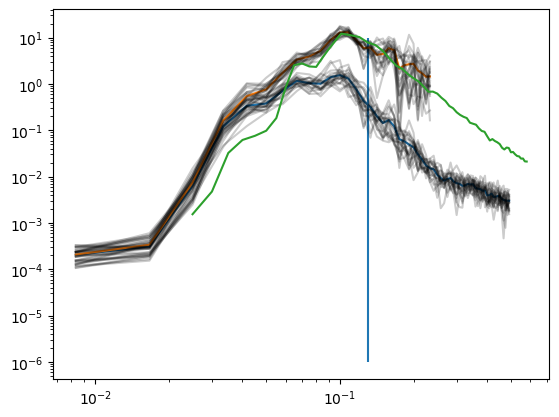

In [431]:
plt.loglog(fwindow, np.nanmean(spec_store_sorted[:, 0, :], axis=0))
#std_raw = np.nanstd(spec_store_sorted[:, 0, :], axis=0)
#plt.fill_between(fwindow, np.nanmean(spec_store_sorted[:, 0, :])-std_raw*2, np.nanmean(spec_store_sorted[:, 0, :])+2*std_raw)
plt.plot(fwindow, np.transpose(spec_store_sorted[:, 0, :]), color='k', alpha=0.2)
plt.loglog(fwindow, np.nanmean(spec_store_sorted[:, 1, :], axis=0))
plt.plot(fwindow, np.transpose(spec_store_sorted[:, 1, :]), color='k', alpha=0.2)

plt.loglog(f, test_spectra)
plt.vlines(x=rotation_rate, ymin=10**-6, ymax=10)
#plt.vlines(x=.1, ymin=10**-6, ymax=10)
#plt.vlines(x=2*rotation_rate, ymin=10**-6, ymax=10)
#plt.vlines(x=3*rotation_rate, ymin=10**-6, ymax=10)
#plt.vlines(x=.1*np.pi, ymin=10**-6, ymax=10)

#plt.fill_between(fwindow[1:],spec_store_sorted_new_corr[ind, :]*uncertainty_store_sorted[ind, 1],spec_store_sorted_new_corr[ind, :]*uncertainty_store_sorted[ind, 0],color='0.8')



Text(0.5, 1.0, 'Dependence on Minimum sampling depth, with typical up/down parameters')

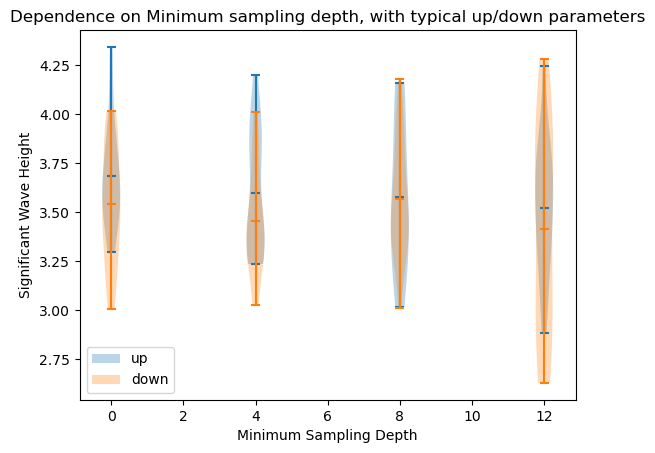

In [420]:
vp1 = plt.violinplot([Hs_df_depth['0_up'], Hs_df_depth['4_up'], Hs_df_depth['8_up'], Hs_df_depth['12_up']], positions=[0, 4, 8, 12], showmeans=True)
vp2 = plt.violinplot([Hs_df_depth['0_down'], Hs_df_depth['4_down'], Hs_df_depth['8_down'], Hs_df_depth['12_down']], positions=[0, 4, 8, 12], showmeans=True)

plt.legend([vp1['bodies'][0],vp2['bodies'][0]], ['up', 'down'], loc=3)
plt.ylabel("Significant Wave Height")
plt.xlabel("Minimum Sampling Depth")
plt.title("Dependence on Minimum sampling depth, with typical up/down parameters")

Text(0.5, 1.0, 'Dependence on rotation rate, with typical up/down parameters')

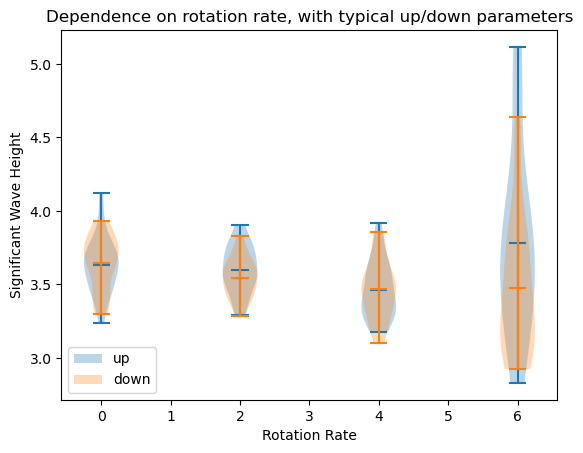

In [415]:
vp1 = plt.violinplot([Hs_df_rates['07_up'], Hs_df_rates['09_up'], Hs_df_rates['11_up'], Hs_df_rates['13_up']], positions=[0,2,4,6], showmeans=True)
vp2 = plt.violinplot([Hs_df_rates['07_down'], Hs_df_rates['09_down'], Hs_df_rates['11_down'], Hs_df_rates['13_down']], positions=[0, 2, 4, 6], showmeans=True)

plt.legend([vp1['bodies'][0],vp2['bodies'][0]], ['up', 'down'], loc=3)
plt.ylabel("Significant Wave Height")
plt.xlabel("Rotation Rate")
plt.title("Dependence on rotation rate, with typical up/down parameters")

Text(0.5, 1.0, 'Dependence on profiling speed, with typical up/down parameters')

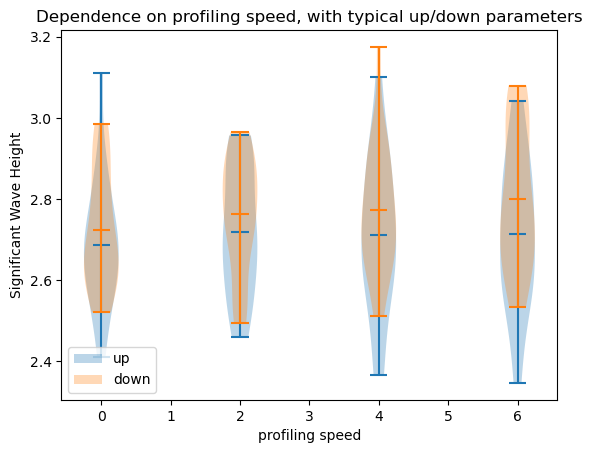

In [421]:
vp1 = plt.violinplot([Hs_df_speeds['11_up'], Hs_df_speeds['13_up'], Hs_df_speeds['15_up'], Hs_df_speeds['17_up']], positions=[0,2,4,6], showmeans=True)
vp2 = plt.violinplot([Hs_df_speeds['11_down'], Hs_df_speeds['13_down'], Hs_df_speeds['15_down'], Hs_df_speeds['17_down']], positions=[0, 2, 4, 6], showmeans=True)

plt.legend([vp1['bodies'][0],vp2['bodies'][0]], ['up', 'down'], loc=3)
plt.ylabel("Significant Wave Height")
plt.xlabel("profiling speed")
plt.title("Dependence on profiling speed, with typical up/down parameters")

In [243]:
Hs_df_speeds

,11_up,11_down,13_up,13_down,15_up,15_down,17_up,17_down
0,3.640870,3.491155,3.708921,3.310953,4.165985,3.616898,3.066874,3.518990
1,3.123045,3.620565,3.552474,3.745526,3.905472,3.957979,4.181978,3.188688
2,3.674285,3.493012,3.656840,3.316423,3.929140,3.733622,4.297414,4.200735
3,3.663214,3.384460,3.425405,3.674971,3.662700,3.895905,3.965859,4.026171
4,3.709742,3.407245,3.768185,3.379990,3.418893,3.319492,3.627655,3.347090
5,3.178987,3.129925,3.416725,3.650398,3.996440,3.743700,4.148971,3.985080
6,3.453277,3.462356,3.803920,3.405739,3.322442,4.624054,4.113393,3.397113
7,3.546254,3.622593,3.673449,3.498652,4.136085,3.715344,3.854110,3.366762
8,3.826602,3.553047,3.800915,3.850509,3.644958,3.979030,4.268230,3.826543
9,3.581241,3.591180,3.653089,3.583573,3.586342,3.805526,4.177416,3.777321


In [6]:
def load_real_positions(positions_fname):
    EFR = loadmat(positions_fname)
    
    
    efr_times = EFR['UXT'] - EFR['AGE']
    efr_times = efr_times[0, :]
    seqno = EFR['SEQNO'][0, :]

    #Fit UXT times to sequence number (measurement # for that profile) to make sure monotonically increasing
    p = np.polyfit(seqno,efr_times,1)
    pfit = np.poly1d(p)
    mlt_efr = pfit(seqno);

    
    #Load CTD file 
    cut = positions_fname.find("efr")
    ctdfname = positions_fname[:cut]+"ctd.mat"
    
    CTD = loadmat(ctdfname)
    
    
    ctd_time = CTD["UXT"][0, :]
    P = CTD["P"][0, :]
    Pef = np.interp(mlt_efr, ctd_time, P)
    
    
    
    #pull out compass values
    HZ = EFR["HZ"][0, :];
    HY = EFR["HY"][0, :];
    HX = EFR["HX"][0, :];
        
    return(Pef, HX, HY, mlt_efr)

In [7]:
# Run simulations using fake rotation rate etc. to compare with loaded roatation rate etc.

fname_base = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/"
float_list = os.listdir(fname_base)
#Load a wave spectra
cdip_fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/229p1_d01.nc"
[times, f, spectra] = load_CDIP(cdip_fname)


load_real = False
uxt_starttime = 1491226592.2198906


for float_id in float_list:
    
    if "grid" in float_id:
        continue
    if ".DS_" in float_id:
        continue
        
    dec_name = fname_base+float_id+"/dec/"
    
    #Loop through each profile for that float
    files = os.listdir(dec_name)
    efr_files = [file for file in files if "efr.mat" in file and not file.startswith('.')]
        #plt.loglog(f, test_spectra)
    #We do an up and a down for each spectra
    for file in efr_files:
        fname = dec_name + file
        prof_num = int(file.split('-')[2])


        EFR = loadmat(fname)
        
        if prof_num%2==0:
            up = True
        else:
            up=False
            
        uVpc = 1e6 * (10e-3 / (2**24))

        alpha2 = 1.95
        alpha1 = alpha2 - np.pi/2
        #Run it all

        #Define some input conditions
        if up:
            start_z = 200
            end_z = 4
            prof_speed = -.12
            rotation_rate = 0.08

        else:
            start_z = 10
            end_z = 200
            prof_speed = .15
            rotation_rate = .115

        sample_rate = 1
        
        efr_times = EFR['UXT'] - EFR['AGE']
        efr_times = efr_times[0, :]
        seqno = EFR['SEQNO'][0, :]

        #Fit UXT times to sequence number (measurement # for that profile) to make sure monotonically increasing
        p = np.polyfit(seqno,efr_times,1)
        pfit = np.poly1d(p)
        mlt_efr = pfit(seqno);

        #Define some mean velocitiy profile
        t_length = np.abs((end_z-start_z)/prof_speed)
        num_samples = np.abs(int(t_length*sample_rate))
        z_range = np.linspace(start_z, end_z, num_samples)
        u_prof = 0.1*np.ones(int(t_length))#np.cos(z_range*2*np.pi/np.max(z_range))
        v_prof = 0.1*np.ones(int(t_length))#np.cos(z_range*2*np.pi/np.max(z_range))


        #build grid
        [em_x, em_y, em_z] = apex_sampling_grid(start_z, end_z, prof_speed, u_prof, v_prof)
    
        
        float_t = np.nanmean(mlt_efr)
        ind2 = np.where(np.abs(float_t-times)==np.min(np.abs(float_t-times)))

        test_spec = spectra[ind2[0][0], :]
    
        theta_spec = np.ones(len(f))*-1*np.pi/4


    
        #Number of simulations to run
        n_iter = 20
        for iteration in range(n_iter):
            avg_lat = 33.474764
            avg_lon = -119.288591

            [Bx, By, Bz, _] = pyIGRF.calculate.igrf12syn(2017.221917808219, 1, 0, avg_lat, avg_lon)
            fz=-np.nanmean(Bz);
            fy = np.nanmean(By)
            [u_store, v_store] = build_u_timeseries(em_x, em_y, em_z, test_spec, f, theta_spec, 1, fy, fz)

            #Add the mean profile
            #u_store = u_store + u_prof
            #v_store = v_store + v_prof
            
            #u_store = u_prof
            #v_store = v_prof


            #u_store = u_prof
            #v_store = v_prof
            #Step 3 get voltages
            
            esep1 = (8+5/8)*0.0254 # m
            esep2 = (8+5/8)*0.0254 # m
            c1 = 0.5 
            Vx = fz*v_store*-1*esep1*(1+c1)/1000
            Vy = -fz*u_store*-1*esep1*(1+c1)/1000


            #Step 4 get the angular orientation of the float and convert voltages channel 1 and channel 2 components
            ch1_angs, ch2_angs = get_channel_angs(t_length, rotation_rate)

            if load_real:
                hx = HX - np.nanmean(HX)
                hx = (hx / np.std(hx)) / np.sqrt(2)
                hy = HY - np.nanmean(HY)
                hy = (hy / np.std(hy)) / np.sqrt(2)

                angs=np.arctan2(hy,hx);
                
                ch1_angs = np.unwrap(angs)
                ch2_angs = np.unwrap(angs) - np.pi/2
               
            #Rotate from magnetometer coordinates
            #Vxr = Vx*np.cos(alpha1)+Vy*np.sin(alpha1)
            #Vyr = Vx*np.sin(alpha1)-Vy*np.cos(alpha1)

            E1 = np.cos(ch1_angs+alpha1)*Vx + np.sin(ch1_angs+alpha1)*Vy
            E2 = -np.cos(ch1_angs+alpha1)*Vy + np.sin(ch1_angs+alpha1)*Vx

            #E1 = Vx
            #E2 = Vy

            #Step 5 add random low frequency offset
            xs = np.linspace(0, int(num_samples), int(num_samples))
            offset = -200-.1*xs + 8*(10**-9)*(xs**2) - 8*(10**-8)*(xs**3)
            #offset = 0
            E1 = E1 #+ offset
            E2 = E2 #+ offset

            E1=(E1/uVpc)+2**23
            E2=(E2/uVpc)+2**23


            #Angles are in magnetometer coordinates
            
            if not load_real:
                HX = np.cos(ch1_angs)*98.6+513.9
                HY = np.sin(ch1_angs)*104.2+420

            
            
            #Now step 6, save it as fake EM data, and run it through the normal pipeline

            #Need to save lat-lon data, Also time data


            #if up:
            #    E1 = np.flip(E1)
            #    E2 = np.flip(E2)
            #    HX = np.flip(HX)
            #    HY = np.flip(HY)
            #    P = np.flip(z_range)
                #xs = np.flip(xs)
                #uxt = np.flip(uxt)

            EFR = {"E1": E1, "E2": E2, "HX": np.expand_dims(HX, axis=0), "HY": np.expand_dims(HY, axis=0), "HZ": np.zeros((1, int(num_samples))), "UXT":np.expand_dims(mlt_efr[0]+xs, axis=0), "AGE": np.zeros((1, int(num_samples))), "SEQNO":np.expand_dims(xs, axis=0)}

            CTD = {"P": np.expand_dims(em_z, axis=0), "UXT":np.expand_dims(mlt_efr[0]+xs, axis=0)}
           
            GPS = {"LAT": np.array([[avg_lat]]), "LON": np.array([[avg_lon]]), "UXT_GPS": np.array([[uxt_starttime]])}
           
            base_savename = "/Users/jamesstadler/Documents/UW/TFO/Data/Simulations/mimic_float_fake_angs_speed/"
            
            if not os.path.exists(base_savename+float_id+"/"):
                os.makedirs(base_savename+float_id+"/dec/")
                #os.makedirs(base_savename+"down/6667g/dec/")          

            cut1 = file.find("-efr")
            file[:cut1]+"-"+str(iteration)           
            savemat(base_savename+float_id+"/dec/"+file[:cut1]+"-"+str(iteration)+"-efr.mat", EFR)
            savemat(base_savename+float_id+"/dec/"+file[:cut1]+"-"+str(iteration)+"-gps.mat", GPS)
            savemat(base_savename+float_id+"/dec/"+file[:cut1]+"-"+str(iteration)+"-ctd.mat", CTD)



In [29]:
# Run simulations loading rotation and holding speed fixed from real floats, and simulated waves

fname_base = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/"
float_list = os.listdir(fname_base)
#Load a wave spectra
cdip_fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/229p1_d01.nc"
[times, f, spectra] = load_CDIP(cdip_fname)


load_real = True
for float_id in float_list:
    
    if "grid" in float_id:
        continue
    if ".DS_" in float_id:
        continue
        
    dec_name = fname_base+float_id+"/dec/"
    
    #Loop through each profile for that float
    files = os.listdir(dec_name)
    efr_files = [file for file in files if "efr.mat" in file and not file.startswith('.')]
        #plt.loglog(f, test_spectra)
    #We do an up and a down for each spectra
    for file in efr_files:
        fname = dec_name + file
        #EFR = loadmat(fname)
        prof_num = int(file.split('-')[2])

        EFR = loadmat(fname)
        
        if prof_num%2==0:
            up = True
        else:
            up=False
            

        uVpc = 1e6 * (10e-3 / (2**24))

        alpha2 = 1.95
        alpha1 = alpha2 - np.pi/2
        #Run it all

        #Define some input conditions
        if up:
            start_z = 200
            end_z = 4
            prof_speed = -.12
            #rotation_rate = 0.08

        else:
            start_z = 10
            end_z = 200
            prof_speed = .15
            #rotation_rate = .115

        sample_rate = 1

        
        
        #build grid
        #[em_x, em_y, em_z] = apex_sampling_grid(start_z, end_z, prof_speed, u_prof, v_prof)
        # build grid
        if load_real:
            [em_z, HX, HY, mlt_efr]=load_real_positions(fname)
            em_x = np.zeros(len(em_z))
            em_y = np.zeros(len(em_z))
            num_samples = len(HX)
            
        #Lets make a fake theta_spec for now:
        #Send all the waves to the southeast.
        theta_spec = np.ones(len(f))*-1*np.pi/4

        #For fixing profilig speed:
        length = len(em_z)
        em_z_new = np.linspace(em_z[0], em_z[-1], length)
        
        
        float_t = np.nanmean(mlt_efr)
        ind2 = np.where(np.abs(float_t-times)==np.min(np.abs(float_t-times)))

        test_spec = spectra[ind2[0][0], :]
    
        #Number of simulations to run
        n_iter = 20
        for iteration in range(n_iter):
            avg_lat = 33.474764
            avg_lon = -119.288591

            [Bx, By, Bz, _] = pyIGRF.calculate.igrf12syn(2017.221917808219, 1, 0, avg_lat, avg_lon)
            fz=-np.nanmean(Bz);
            fy = np.nanmean(By)
            [u_store, v_store] = build_u_timeseries(em_x, em_y, em_z_new, test_spec, f, theta_spec, 1, fy, fz)

            #Add the mean profile
            #u_store = u_store + u_prof
            #v_store = v_store + v_prof
            
            #u_store = u_prof
            #v_store = v_prof


            #u_store = u_prof
            #v_store = v_prof
            #Step 3 get voltages
            
            esep1 = (8+5/8)*0.0254 # m
            esep2 = (8+5/8)*0.0254 # m
            c1 = 0.5 
            Vx = fz*v_store*-1*esep1*(1+c1)/1000
            Vy = -fz*u_store*-1*esep1*(1+c1)/1000


            #Step 4 get the angular orientation of the float and convert voltages channel 1 and channel 2 components
            ch1_angs, ch2_angs = get_channel_angs(t_length, rotation_rate)

            if load_real:
                hx = HX - np.nanmean(HX)
                hx = (hx / np.std(hx)) / np.sqrt(2)
                hy = HY - np.nanmean(HY)
                hy = (hy / np.std(hy)) / np.sqrt(2)

                angs=np.arctan2(hy,hx);
                
                ch1_angs = np.unwrap(angs)
                ch2_angs = np.unwrap(angs) - np.pi/2
               
            #Rotate from magnetometer coordinates
            #Vxr = Vx*np.cos(alpha1)+Vy*np.sin(alpha1)
            #Vyr = Vx*np.sin(alpha1)-Vy*np.cos(alpha1)

            E1 = np.cos(ch1_angs+alpha1)*Vx + np.sin(ch1_angs+alpha1)*Vy
            E2 = -np.cos(ch1_angs+alpha1)*Vy + np.sin(ch1_angs+alpha1)*Vx

            #E1 = Vx
            #E2 = Vy

            #Step 5 add random low frequency offset
            xs = np.linspace(0, int(num_samples), int(num_samples))
            offset = -200-.1*xs + 8*(10**-9)*(xs**2) - 8*(10**-8)*(xs**3)
            #offset = 0
            E1 = E1 #+ offset
            E2 = E2 #+ offset

            E1=(E1/uVpc)+2**23
            E2=(E2/uVpc)+2**23


            #Angles are in magnetometer coordinates
            
            if not load_real:
                HX = np.cos(ch1_angs)*98.6+513.9
                HY = np.sin(ch1_angs)*104.2+420

            
            
            #Now step 6, save it as fake EM data, and run it through the normal pipeline

            #Need to save lat-lon data, Also time data


            #if up:
            #    E1 = np.flip(E1)
            #    E2 = np.flip(E2)
            #    HX = np.flip(HX)
            #    HY = np.flip(HY)
            #    P = np.flip(z_range)
                #xs = np.flip(xs)
                #uxt = np.flip(uxt)

            EFR = {"E1": E1, "E2": E2, "HX": np.expand_dims(HX, axis=0), "HY": np.expand_dims(HY, axis=0), "HZ": np.zeros((1, int(num_samples))), "UXT":np.expand_dims(mlt_efr, axis=0), "AGE": np.zeros((1, int(num_samples))), "SEQNO":np.expand_dims(xs, axis=0)}

            CTD = {"P": np.expand_dims(em_z_new, axis=0), "UXT":np.expand_dims(mlt_efr, axis=0)}
           
            GPS = {"LAT": np.array([[avg_lat]]), "LON": np.array([[avg_lon]]), "UXT_GPS": np.array([[uxt_starttime]])}
           
            base_savename = "/Users/jamesstadler/Documents/UW/TFO/Data/Simulations/mimic_float_fake_speed/"
            
            if not os.path.exists(base_savename+float_id+"/"):
                os.makedirs(base_savename+float_id+"/dec/")
                #os.makedirs(base_savename+"down/6667g/dec/")          

            cut1 = file.find("-efr")
            file[:cut1]+"-"+str(iteration)           
            savemat(base_savename+float_id+"/dec/"+file[:cut1]+"-"+str(iteration)+"-efr.mat", EFR)
            savemat(base_savename+float_id+"/dec/"+file[:cut1]+"-"+str(iteration)+"-gps.mat", GPS)
            savemat(base_savename+float_id+"/dec/"+file[:cut1]+"-"+str(iteration)+"-ctd.mat", CTD)



In [77]:
# Run simulations loading speed data from real floats and holding rotation rate fixed, and simulated waves

fname_base = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/"
float_list = os.listdir(fname_base)
#Load a wave spectra
cdip_fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/229p1_d01.nc"
[times, f, spectra] = load_CDIP(cdip_fname)

#Settting this to false changes default to using the fake angles
load_real = False
for float_id in float_list:
    
    if "grid" in float_id:
        continue
    if ".DS_" in float_id:
        continue
        
    dec_name = fname_base+float_id+"/dec/"
    
    #Loop through each profile for that float
    files = os.listdir(dec_name)
    efr_files = [file for file in files if "efr.mat" in file and not file.startswith('.')]
        #plt.loglog(f, test_spectra)
    #We do an up and a down for each spectra
    for file in efr_files:
        fname = dec_name + file
        #EFR = loadmat(fname)
        prof_num = int(file.split('-')[2])

        EFR = loadmat(fname)
        
        if prof_num%2==0:
            up = True
        else:
            up=False
            

        uVpc = 1e6 * (10e-3 / (2**24))

        alpha2 = 1.95
        alpha1 = alpha2 - np.pi/2
        #Run it all

        #Define some input conditions
        if up:
            start_z = 200
            end_z = 4
            prof_speed = -.12
            rotation_rate = 0.08

        else:
            start_z = 10
            end_z = 200
            prof_speed = .15
            rotation_rate = .115

        sample_rate = 1

        

        [em_z, HX, HY, mlt_efr]=load_real_positions(fname)
        em_x = np.zeros(len(em_z))
        em_y = np.zeros(len(em_z))
        num_samples = len(HX)

        #Lets make a fake theta_spec for now:
        #Send all the waves to the southeast.
        theta_spec = np.ones(len(f))*-1*np.pi/4
        
        
        float_t = np.nanmean(mlt_efr)
        ind2 = np.where(np.abs(float_t-times)==np.min(np.abs(float_t-times)))

        test_spec = spectra[ind2[0][0], :]
    
    
        #Number of simulations to run
        n_iter = 20
        for iteration in range(n_iter):
            avg_lat = 33.474764
            avg_lon = -119.288591

            [Bx, By, Bz, _] = pyIGRF.calculate.igrf12syn(2017.221917808219, 1, 0, avg_lat, avg_lon)
            fz=-np.nanmean(Bz);
            fy = np.nanmean(By)
            [u_store, v_store] = build_u_timeseries(em_x, em_y, em_z, test_spec, f, theta_spec, 1, fy, fz)

            #Add the mean profile
            #u_store = u_store + u_prof
            #v_store = v_store + v_prof
            
            #u_store = u_prof
            #v_store = v_prof


            #u_store = u_prof
            #v_store = v_prof
            #Step 3 get voltages
            
            esep1 = (8+5/8)*0.0254 # m
            esep2 = (8+5/8)*0.0254 # m
            c1 = 0.5 
            Vx = fz*v_store*-1*esep1*(1+c1)/1000
            Vy = -fz*u_store*-1*esep1*(1+c1)/1000

            t_length = num_samples
            #Step 4 get the angular orientation of the float and convert voltages channel 1 and channel 2 components
            ch1_angs, ch2_angs = get_channel_angs(t_length, rotation_rate)

            if load_real:
                hx = HX - np.nanmean(HX)
                hx = (hx / np.std(hx)) / np.sqrt(2)
                hy = HY - np.nanmean(HY)
                hy = (hy / np.std(hy)) / np.sqrt(2)

                angs=np.arctan2(hy,hx);
                
                ch1_angs = np.unwrap(angs)
                ch2_angs = np.unwrap(angs) - np.pi/2
               
            #Rotate from magnetometer coordinates
            #Vxr = Vx*np.cos(alpha1)+Vy*np.sin(alpha1)
            #Vyr = Vx*np.sin(alpha1)-Vy*np.cos(alpha1)

            E1 = np.cos(ch1_angs+alpha1)*Vx + np.sin(ch1_angs+alpha1)*Vy
            E2 = -np.cos(ch1_angs+alpha1)*Vy + np.sin(ch1_angs+alpha1)*Vx

            #E1 = Vx
            #E2 = Vy

            #Step 5 add random low frequency offset
            xs = np.linspace(0, int(num_samples), int(num_samples))
            offset = -200-.1*xs + 8*(10**-9)*(xs**2) - 8*(10**-8)*(xs**3)
            #offset = 0
            E1 = E1 #+ offset
            E2 = E2 #+ offset

            E1=(E1/uVpc)+2**23
            E2=(E2/uVpc)+2**23


            #Angles are in magnetometer coordinates
            
            if not load_real:
                HX = np.cos(ch1_angs)*98.6+513.9
                HY = np.sin(ch1_angs)*104.2+420

            
            
            #Now step 6, save it as fake EM data, and run it through the normal pipeline

            #Need to save lat-lon data, Also time data


            #if up:
            #    E1 = np.flip(E1)
            #    E2 = np.flip(E2)
            #    HX = np.flip(HX)
            #    HY = np.flip(HY)
            #    P = np.flip(z_range)
                #xs = np.flip(xs)
                #uxt = np.flip(uxt)

            EFR = {"E1": E1, "E2": E2, "HX": np.expand_dims(HX, axis=0), "HY": np.expand_dims(HY, axis=0), "HZ": np.zeros((1, int(num_samples))), "UXT":np.expand_dims(mlt_efr, axis=0), "AGE": np.zeros((1, int(num_samples))), "SEQNO":np.expand_dims(xs, axis=0)}

            CTD = {"P": np.expand_dims(em_z, axis=0), "UXT":np.expand_dims(mlt_efr, axis=0)}
           
            GPS = {"LAT": np.array([[avg_lat]]), "LON": np.array([[avg_lon]]), "UXT_GPS": np.array([[uxt_starttime]])}
           
            base_savename = "/Users/jamesstadler/Documents/UW/TFO/Data/Simulations/mimic_float_fake_angs/"
            
            if not os.path.exists(base_savename+float_id+"/"):
                os.makedirs(base_savename+float_id+"/dec/")
                #os.makedirs(base_savename+"down/6667g/dec/")          

            cut1 = file.find("-efr")
            file[:cut1]+"-"+str(iteration)           
            savemat(base_savename+float_id+"/dec/"+file[:cut1]+"-"+str(iteration)+"-efr.mat", EFR)
            savemat(base_savename+float_id+"/dec/"+file[:cut1]+"-"+str(iteration)+"-gps.mat", GPS)
            savemat(base_savename+float_id+"/dec/"+file[:cut1]+"-"+str(iteration)+"-ctd.mat", CTD)


In [34]:
# Run simulations with loaded roatation rate and speed.

fname_base = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/"
float_list = os.listdir(fname_base)
#Load a wave spectra
cdip_fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/229p1_d01.nc"
[times, f, spectra] = load_CDIP(cdip_fname)


load_real = True
uxt_starttime = 1491226592.2198906


for float_id in float_list:
    
    if "grid" in float_id:
        continue
    if ".DS_" in float_id:
        continue
        
    dec_name = fname_base+float_id+"/dec/"
    
    #Loop through each profile for that float
    files = os.listdir(dec_name)
    efr_files = [file for file in files if "efr.mat" in file and not file.startswith('.')]
        #plt.loglog(f, test_spectra)
    #We do an up and a down for each spectra
    for file in efr_files:
        fname = dec_name + file
        prof_num = int(file.split('-')[2])


        EFR = loadmat(fname)
        
        if prof_num%2==0:
            up = True
        else:
            up=False
            
        uVpc = 1e6 * (10e-3 / (2**24))

        alpha2 = 1.95
        alpha1 = alpha2 - np.pi/2
        #Run it all

        
        sample_rate = 1
        
        efr_times = EFR['UXT'] - EFR['AGE']
        efr_times = efr_times[0, :]
        seqno = EFR['SEQNO'][0, :]

        #Fit UXT times to sequence number (measurement # for that profile) to make sure monotonically increasing
        p = np.polyfit(seqno,efr_times,1)
        pfit = np.poly1d(p)
        mlt_efr = pfit(seqno);

        #Define some mean velocitiy profile
        

        #build grid
        #[em_x, em_y, em_z] = apex_sampling_grid(start_z, end_z, prof_speed, u_prof, v_prof)
        [em_z, HX, HY, mlt_efr]=load_real_positions(fname)
        em_x = np.zeros(len(em_z))
        em_y = np.zeros(len(em_z))
        num_samples = len(HX)
        
        float_t = np.nanmean(mlt_efr)
        ind2 = np.where(np.abs(float_t-times)==np.min(np.abs(float_t-times)))

        test_spec = spectra[ind2[0][0], :]
    
        theta_spec = np.ones(len(f))*-1*np.pi/4


    
        #Number of simulations to run
        n_iter = 50
        for iteration in range(n_iter):
            avg_lat = 33.474764
            avg_lon = -119.288591

            [Bx, By, Bz, _] = pyIGRF.calculate.igrf12syn(2017.221917808219, 1, 0, avg_lat, avg_lon)
            fz=-np.nanmean(Bz);
            fy = np.nanmean(By)
            [u_store, v_store] = build_u_timeseries(em_x, em_y, em_z, test_spec, f, theta_spec, 1, fy, fz)

            #Add the mean profile
            #u_store = u_store + u_prof
            #v_store = v_store + v_prof
            
            #u_store = u_prof
            #v_store = v_prof


            #u_store = u_prof
            #v_store = v_prof
            #Step 3 get voltages
            
            esep1 = (8+5/8)*0.0254 # m
            esep2 = (8+5/8)*0.0254 # m
            c1 = 0.5 
            Vx = fz*v_store*-1*esep1*(1+c1)/1000
            Vy = -fz*u_store*-1*esep1*(1+c1)/1000


            #Step 4 get the angular orientation of the float and convert voltages channel 1 and channel 2 components
            #ch1_angs, ch2_angs = get_channel_angs(t_length, rotation_rate)

            if load_real:
                hx = HX - np.nanmean(HX)
                hx = (hx / np.std(hx)) / np.sqrt(2)
                hy = HY - np.nanmean(HY)
                hy = (hy / np.std(hy)) / np.sqrt(2)

                angs=np.arctan2(hy,hx);
                
                ch1_angs = np.unwrap(angs)
                ch2_angs = np.unwrap(angs) - np.pi/2
               
            #Rotate from magnetometer coordinates
            #Vxr = Vx*np.cos(alpha1)+Vy*np.sin(alpha1)
            #Vyr = Vx*np.sin(alpha1)-Vy*np.cos(alpha1)

            E1 = np.cos(ch1_angs+alpha1)*Vx + np.sin(ch1_angs+alpha1)*Vy
            E2 = -np.cos(ch1_angs+alpha1)*Vy + np.sin(ch1_angs+alpha1)*Vx

            #E1 = Vx
            #E2 = Vy
            num_samples = len(mlt_efr)
            #Step 5 add random low frequency offset
            xs = np.linspace(0, int(num_samples), int(num_samples))
            offset = -200-.1*xs + 8*(10**-9)*(xs**2) - 8*(10**-8)*(xs**3)
            #offset = 0
            E1 = E1 #+ offset
            E2 = E2 #+ offset

            E1=(E1/uVpc)+2**23
            E2=(E2/uVpc)+2**23


            #Angles are in magnetometer coordinates
            
            if not load_real:
                HX = np.cos(ch1_angs)*98.6+513.9
                HY = np.sin(ch1_angs)*104.2+420

            
            
            #Now step 6, save it as fake EM data, and run it through the normal pipeline

            #Need to save lat-lon data, Also time data


            #if up:
            #    E1 = np.flip(E1)
            #    E2 = np.flip(E2)
            #    HX = np.flip(HX)
            #    HY = np.flip(HY)
            #    P = np.flip(z_range)
                #xs = np.flip(xs)
                #uxt = np.flip(uxt)

            EFR = {"E1": E1, "E2": E2, "HX": np.expand_dims(HX, axis=0), "HY": np.expand_dims(HY, axis=0), "HZ": np.zeros((1, int(len(HX)))), "UXT":np.expand_dims(mlt_efr, axis=0), "AGE": np.zeros((1, int(len(mlt_efr)))), "SEQNO":np.expand_dims(xs, axis=0)}

            CTD = {"P": np.expand_dims(em_z, axis=0), "UXT":np.expand_dims(mlt_efr, axis=0)}
           
            GPS = {"LAT": np.array([[avg_lat]]), "LON": np.array([[avg_lon]]), "UXT_GPS": np.array([[uxt_starttime]])}
           
            base_savename = "/Users/jamesstadler/Documents/UW/TFO/Data/Simulations/mimic_float/"
            
            if not os.path.exists(base_savename+float_id+"/"):
                os.makedirs(base_savename+float_id+"/dec/")
                #os.makedirs(base_savename+"down/6667g/dec/")          

            cut1 = file.find("-efr")
            file[:cut1]+"-"+str(iteration)           
            savemat(base_savename+float_id+"/dec/"+file[:cut1]+"-"+str(iteration)+"-efr.mat", EFR)
            savemat(base_savename+float_id+"/dec/"+file[:cut1]+"-"+str(iteration)+"-gps.mat", GPS)
            savemat(base_savename+float_id+"/dec/"+file[:cut1]+"-"+str(iteration)+"-ctd.mat", CTD)




In [78]:
#Loading and processing all the different simulations
#Do this for each of the variables
warnings.filterwarnings('ignore')
base_savename = "/Users/jamesstadler/Documents/UW/TFO/Data/Simulations/mimic_float/"
[spec_store_sorted_mim, time_store_sorted_mim, uncertainty_store_sorted_mim, up_down_store_sorted_mim, loc_store_sorted, prof_store_sorted, fwindow] = process_files(base_savename)
spec_store_sorted_new_corr = add_hf_tail(spec_store_sorted_mim[:, 1, :], fwindow)
[Hs_mimiced,lower,upper] = sig_wave_height(fwindow, np.transpose(spec_store_sorted_new_corr))

base_savename = "/Users/jamesstadler/Documents/UW/TFO/Data/Simulations/mimic_float_fake_speed/"
[spec_store_sorted_spd, time_store_sorted_spd, uncertainty_store_sorted_spd, up_down_store_sorted_spd, loc_store_sorted, prof_store_sorted, fwindow] = process_files(base_savename)
spec_store_sorted_new_corr = add_hf_tail(spec_store_sorted_spd[:, 1, :], fwindow)
[Hs_fake_speed,lower,upper] = sig_wave_height(fwindow, np.transpose(spec_store_sorted_new_corr))

base_savename = "/Users/jamesstadler/Documents/UW/TFO/Data/Simulations/mimic_float_fake_angs/"
[spec_store_sorted_ang, time_store_sorted_ang, uncertainty_store_sorted_ang, up_down_store_sorted_ang, loc_store_sorted, prof_store_sorted, fwindow] = process_files(base_savename)
spec_store_sorted_new_corr = add_hf_tail(spec_store_sorted_ang[:, 1, :], fwindow)
[Hs_fake_angs,lower,upper] = sig_wave_height(fwindow, np.transpose(spec_store_sorted_new_corr))

base_savename = "/Users/jamesstadler/Documents/UW/TFO/Data/Simulations/mimic_float_fake_angs_speed/"
[spec_store_sorted_angspd, time_store_sorted_angspd, uncertainty_store_sorted_angspd, up_down_store_sorted_angspd, loc_store_sorted, prof_store_sorted, fwindow] = process_files(base_savename)
spec_store_sorted_new_corr = add_hf_tail(spec_store_sorted_angspd[:, 1, :], fwindow)
[Hs_fake_angs_speed,lower,upper] = sig_wave_height(fwindow, np.transpose(spec_store_sorted_new_corr))


nc = netcdf.NetCDFFile(cdip_fname, 'r', mmap=False) #Not sure why I need to do mmap = False but it gets rid of a warning
times = nc.variables['waveTime'][:]
ts = np.array([datetime.datetime.fromtimestamp(t) for t in times])
Hs_cdip = nc.variables['waveHs'][:]
energy_density = nc.variables['waveEnergyDensity'][:]
wave_freq = nc.variables['waveFrequency'][:]
cdip_lat = np.nanmean(nc.variables['gpsLatitude'][:])
cdip_lon = np.nanmean(nc.variables['gpsLongitude'][:])


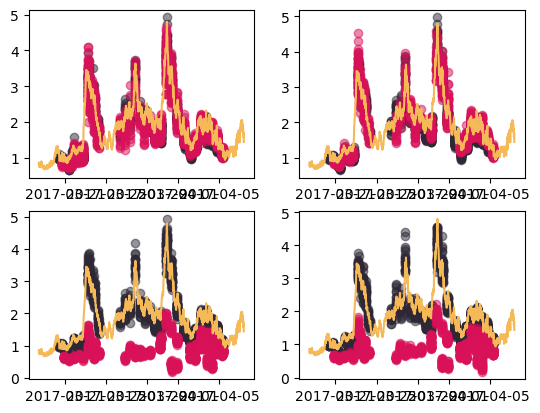

In [79]:
# PLotting

#plt.plot(t_apex, Hs_corr, '--C4', label='EM-APEX corrected')
plt.subplot(221)
t_apex = np.array([datetime.datetime.fromtimestamp(t) for t in time_store_sorted_angspd])
ups = np.where(up_down_store_sorted_angspd==1)[0]
downs = np.where(up_down_store_sorted_angspd==0)[0]
plt.scatter(t_apex[ups], Hs_fake_angs_speed[ups], color=gray_color, linewidth=1, alpha=0.5, label='Ups')
plt.scatter(t_apex[downs], Hs_fake_angs_speed[downs], color=red_color, linewidth=1, alpha=0.5, label='Downs')




#plt.plot(t_apex, Hs_corr, '--C4', label='EM-APEX corrected')
plt.plot(ts, Hs_cdip, label='CDIP', color=cdip_color)
plt.subplot(222)
t_apex = np.array([datetime.datetime.fromtimestamp(t) for t in time_store_sorted_spd])
ups = np.where(up_down_store_sorted_spd==1)[0]
downs = np.where(up_down_store_sorted_spd==0)[0]
plt.scatter(t_apex[ups], Hs_fake_speed[ups], color=gray_color, linewidth=1, alpha=0.5, label='Ups')
plt.scatter(t_apex[downs], Hs_fake_speed[downs], color=red_color, linewidth=1, alpha=0.5, label='Downs')


#plt.plot(t_apex, Hs_corr, '--C4', label='EM-APEX corrected')
plt.plot(ts, Hs_cdip, label='CDIP', color=cdip_color)


#plt.plot(t_apex, Hs_corr, '--C4', label='EM-APEX corrected')
plt.subplot(223)
t_apex = np.array([datetime.datetime.fromtimestamp(t) for t in time_store_sorted_ang])
ups = np.where(up_down_store_sorted_ang==1)[0]
downs = np.where(up_down_store_sorted_ang==0)[0]
plt.scatter(t_apex[ups], Hs_fake_angs[ups], color=gray_color, linewidth=1, alpha=0.5, label='Ups')
plt.scatter(t_apex[downs], Hs_fake_angs[downs], color=red_color, linewidth=1, alpha=0.5, label='Downs')


#plt.plot(t_apex, Hs_corr, '--C4', label='EM-APEX corrected')
plt.plot(ts, Hs_cdip, label='CDIP', color=cdip_color)

plt.subplot(224)
t_apex = np.array([datetime.datetime.fromtimestamp(t) for t in time_store_sorted_mim])
ups = np.where(up_down_store_sorted_mim==1)[0]
downs = np.where(up_down_store_sorted_mim==0)[0]
plt.scatter(t_apex[ups], Hs_mimiced[ups], color=gray_color, linewidth=1, alpha=0.5, label='Ups')
plt.scatter(t_apex[downs], Hs_mimiced[downs], color=red_color, linewidth=1, alpha=0.5, label='Downs')




#plt.plot(t_apex, Hs_corr, '--C4', label='EM-APEX corrected')
plt.plot(ts, Hs_cdip, label='CDIP', color=cdip_color)



Text(0.5, 1.0, 'Simulated Significant Wave heights (constant w, constant rotataion)')

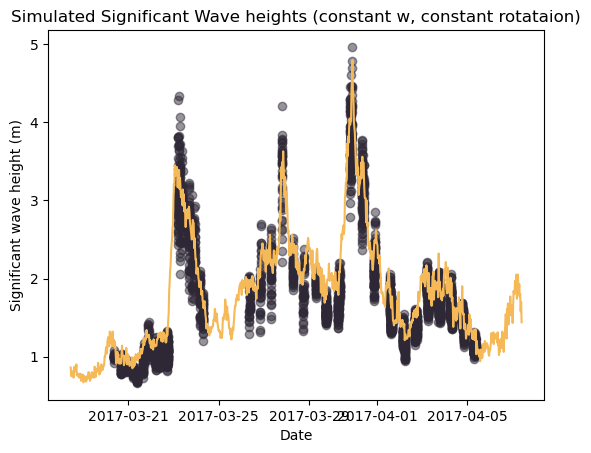

In [9]:
base_savename = "/Users/jamesstadler/Documents/UW/TFO/Data/Simulations/mimic_float_fake_angs_speed/"
[spec_store_sorted, time_store_sorted, uncertainty_store_sorted, up_down_store_sorted, loc_store_sorted, prof_store_sorted, fwindow] = process_files(base_savename)


spec_store_sorted_new_corr = add_hf_tail(spec_store_sorted[:, 1, :], fwindow)

[Hs_fake_angs_speed,lower,upper] = sig_wave_height(fwindow, np.transpose(spec_store_sorted_new_corr))
t_apex = np.array([datetime.datetime.fromtimestamp(t) for t in time_store_sorted])


nc = netcdf.NetCDFFile(cdip_fname, 'r', mmap=False) #Not sure why I need to do mmap = False but it gets rid of a warning
times = nc.variables['waveTime'][:]
ts = np.array([datetime.datetime.fromtimestamp(t) for t in times])
Hs_cdip = nc.variables['waveHs'][:]
energy_density = nc.variables['waveEnergyDensity'][:]
wave_freq = nc.variables['waveFrequency'][:]
cdip_lat = np.nanmean(nc.variables['gpsLatitude'][:])
cdip_lon = np.nanmean(nc.variables['gpsLongitude'][:])


ups = np.where(up_down_store_sorted==1)[0]
downs = np.where(up_down_store_sorted==0)[0]

plt.scatter(t_apex, Hs_fake_angs_speed, color=gray_color, linewidth=1, alpha=0.5, label='Ups')
#plt.scatter(t_apex[downs], Hs_fake_angs_speed[downs], color=red_color, linewidth=1, alpha=0.5, label='Downs')


#plt.plot(t_apex, Hs_corr, '--C4', label='EM-APEX corrected')
plt.plot(ts, Hs_cdip, label='CDIP', color=cdip_color)
plt.ylabel("Significant wave height (m)")
plt.xlabel("Date")
plt.title("Simulated Significant Wave heights (constant w, constant rotataion)")



In [28]:
warnings.filterwarnings('ignore')
base_savename = "/Users/jamesstadler/Documents/UW/TFO/Data/Simulations/mimic_float/"
[spec_store_sorted_mim, time_store_sorted_mim, uncertainty_store_sorted_mim, up_down_store_sorted_mim, loc_store_sorted, prof_store_sorted, fwindow] = process_files(base_savename)
spec_store_sorted_new_corr_mim = add_hf_tail(spec_store_sorted_mim[:, 1, :], fwindow)
[Hs_mimiced,lower,upper] = sig_wave_height(fwindow, np.transpose(spec_store_sorted_new_corr))



<ErrorbarContainer object of 3 artists>

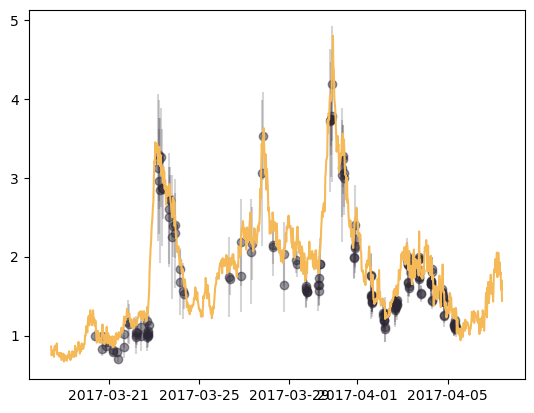

In [33]:
#Block for averaging simulation measurements with the same timestamp and storing mean/std

t_apex_uniques = np.array([])
for t in t_apex:
    if t in t_apex_uniques:
        continue
    else:
        t_apex_uniques = np.append(t_apex_uniques, [t])
        
Hs_means_sim = np.array([])
Hs_stds_sim = np.array([])
Hs_means_mim = np.array([])
Hs_stds_mim = np.array([])
for t in t_apex_uniques:
    inds = np.where(t_apex==t)
    avg_sim = np.nanmean(Hs_fake_angs_speed[inds])
    stdeviation_sim = np.nanstd(Hs_fake_angs_speed[inds])
    
    avg_mim = np.nanmean(Hs_mimiced[inds])
    stdeviation_mim = np.nanstd(Hs_mimiced[inds])
    
    Hs_means_sim = np.append(Hs_means_sim, [avg_sim])
    Hs_stds_sim = np.append(Hs_stds_sim, [stdeviation_sim])
    Hs_means_mim = np.append(Hs_means_mim, [avg_mim])
    Hs_stds_mim = np.append(Hs_stds_mim, [stdeviation_mim])



    
plt.plot(ts, Hs_cdip, label='CDIP', color=cdip_color)
plt.scatter(t_apex_uniques, Hs_means_sim, color=gray_color, linewidth=1, alpha=0.5, label='Sim')
plt.errorbar(t_apex_uniques, Hs_means_sim, yerr=2*Hs_stds_sim, color=gray_color, alpha=0.2, fmt='none')

# plt.scatter(t_apex_uniques, Hs_means_mim, color=gray_color, linewidth=1, alpha=0.5, label='Sim')
# plt.errorbar(t_apex_uniques, Hs_means_mim, yerr=2*Hs_stds_mim, color=red_color, alpha=0.2, fmt='none')

Text(0, 0.5, 'Simulation Wave Heights')

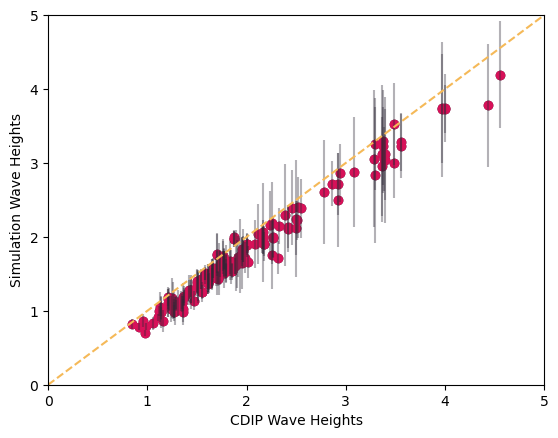

In [32]:
##Get Errors
#first need to match up the times
t_apex_timestamps = np.array([datetime.datetime.timestamp(t) for t in t_apex_uniques])

cdip_inds = np.array([], dtype=int)
for ind in range(0, len(t_apex_timestamps)):
    ind2 = np.where(np.abs(t_apex_timestamps[ind]-times)==np.min(np.abs(t_apex_timestamps[ind]-times)))
    cdip_inds = np.append(cdip_inds, ind2[0])

    
plt.errorbar(Hs_cdip[cdip_inds], Hs_means_sim, yerr = 2*Hs_stds_sim, color=gray_color, alpha=0.2, fmt='none')
plt.scatter(Hs_cdip[cdip_inds], Hs_means_sim, color=gray_color, label="Simulation")

# plt.errorbar(Hs_cdip[cdip_inds], Hs_means_mim, yerr = 2*Hs_stds_mim, color=gray_color, alpha=0.2, fmt='none')
# plt.scatter(Hs_cdip[cdip_inds], Hs_means_mim, color=red_color, label="Simulation")
y = np.arange(0, 6, 0.1)
plt.plot(np.arange(0, 6, 0.1), y, '--',color=cdip_color, label="1:1")
plt.xlim([0, 5])
plt.ylim([0, 5])
plt.xlabel("CDIP Wave Heights")
plt.ylabel("Simulation Wave Heights")

In [133]:
cols = [str(starts[i]) for i in range(len(starts))]
Hs_df_ups= pd.DataFrame(data=np.zeros((n_iter, len(cols))), columns=cols)
Hs_df_downs = pd.DataFrame(data=np.zeros((n_iter, len(cols))), columns=cols)
Hs_cdip_df = pd.DataFrame(data=np.zeros((1, len(cols))), columns=cols)

for start in starts:
    for i in range(2):
        if i==0:
            base_savename = "/Users/jamesstadler/Documents/UW/TFO/Data/Simulations/up_vs_down/"+str(start)+"/up/"
        else:
            base_savename = "/Users/jamesstadler/Documents/UW/TFO/Data/Simulations/up_vs_down/"+str(start)+"/down/"



        [spec_store_sorted, time_store_sorted, uncertainty_store_sorted, up_down_store_sorted, loc_store_sorted, prof_store_sorted, fwindow] = process_files(base_savename)

   
        spec_store_sorted_new_corr = add_hf_tail(spec_store_sorted[:, 1, :], fwindow)
        sig_wave_array = [];

        [Hs,lower,upper] = sig_wave_height(fwindow, np.transpose(spec_store_sorted_new_corr))
        [Hs_cdip, lower, upper]= sig_wave_height(f, np.mean(spectra[start:start+4, :], 0))
        Hs_cdip_df[str(start)] = Hs_cdip
        if i==0:
            Hs_df_ups[str(start)] = Hs
            #if start%6==0:
            #    plt.figure()
            #    plt.loglog(fwindow, spec_store_sorted_new_corr[0, :])
        else:
            Hs_df_downs[str(start)] = Hs
            #if start%6==0:
             #   plt.loglog(fwindow, spec_store_sorted_new_corr[0, :])
              #  plt.loglog(f, np.mean(spectra[start:start+4, :], 0))
       

Text(0.5, 1.0, 'Simulated significant wave height measurements for up and down profiles')

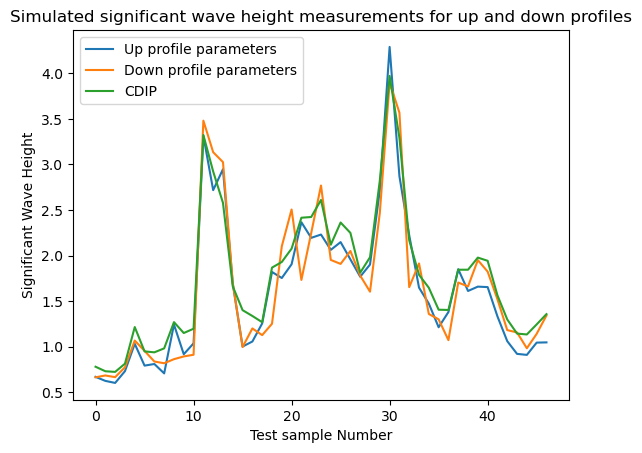

In [134]:
#Try adding 
up_means = Hs_df_ups.mean(axis=0)
down_means = Hs_df_downs.mean(axis=0)
plt.plot(np.linspace(0, 46, 47), up_means, label="Up profile parameters")
plt.plot(np.linspace(0, 46, 47), down_means, label="Down profile parameters")
plt.plot(np.linspace(0, 46, 47), Hs_cdip_df.iloc[0, :], label="CDIP")
plt.ylabel("Significant Wave Height")
plt.xlabel("Test sample Number")
plt.legend()
plt.title("Simulated significant wave height measurements for up and down profiles")


Ideas for why this maybe is working in the simulation but not real life:

1. There's something wrong about how I'm producing the surface waves discretely --> Maybe I'm missing a component at the rotation frequency or something?

2. Variation in profiling speed & rotation rate within windows and across windows is important somehow

3. There's some error in the fitting procedure in real life that I'm not mimicing in the model... maybe a tilt in the float as it descends that introduces a modulation in the basis function or something that causes error?


4. Something with the vertical motion of the float induced magnetic field thing that I've been ignoring plays a role in the different speeds error...

5. error in the magentometer introduces some error around the rotation frequency...